In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.optimize as opt

In [2]:
N=int(2e4)
X=np.zeros([3,N])
X[:,0]=[10,10,1]
dt=1e-3

s = 16
r = 45.92
b = 4

def stepx(X,s=16,r=45.92,b=4):
    x,y,z = X
    xn = x + dt*(-s*(x-y)) 
    yn = y + dt*( -x*z + r*x - y)  
    zn = z + dt*( x*y - b*z) 
    return np.array([xn,yn,zn])

def simulateX(x0,T,dt=dt,s=16,r=45.92,b=4):
    N=int(T/dt)
    X=np.zeros([N,3])
    X[0]=x0
    for i in range(1,N):
        X[i]=stepx(X[i-1])
    return X

T=10
Xtrue=simulateX(np.array([10,10,10])+10*np.random.randn(3),T)

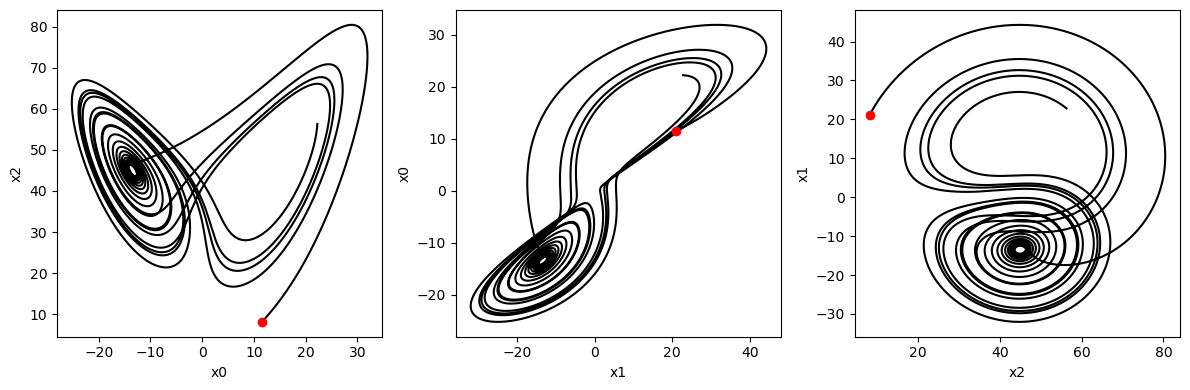

In [3]:
d0l=np.arange(0,3)
d1l=np.roll(d0l,1)
fig,axs=plt.subplots(1,3,figsize=(12,4))
for i,d0,d1 in zip(range(0,3),d0l,d1l):
    axs[i].plot(Xtrue[:,d0],Xtrue[:,d1],'k-',alpha=1)
    axs[i].plot(Xtrue[0,d0],Xtrue[0,d1],'ro')
    axs[i].set_xlabel(f'x{d0}')
    axs[i].set_ylabel(f'x{d1}')
fig.tight_layout()

In [4]:
# calculate the cost function J
def evaluateCostfunction(x0,xb,zobs,Tassim,Tobs,Hobs,Ri,Bi,dt):

    nobs = int(Tassim/Tobs)

    xf = simulateX(x0,Tassim,dt=dt)[::int(Tobs/dt)]
    
    Jb = np.dot( np.dot(xb-x0, Bi), xb-x0 ) 
    
    for i in range(0,nobs):
        Jo = np.dot( np.dot(zobs[i]-np.dot(Hobs,xf[i]), Ri), zobs[i]-np.dot(Hobs,xf[i]) )

    return Jo+Jb

In [5]:
# calculate the background covariance matrix 
Xanom=Xtrue-Xtrue.mean(axis=0)
B = np.dot(Xanom.T,Xanom)
Bi=la.inv(B)

#set the observation operator and set the noise level 
robs=0.5
Ndim = 3
if Ndim == 1:
    R=np.array([[robs]])
    Hobs=np.array([[1,0,0]])
elif Ndim == 3:
    R=np.eye(3)*robs
    Hobs=np.eye(3)
Ri=la.inv(R)

# set the sampling rate 
Nobs=25
Nassim=500
Tassim=Nassim*dt
Tobs=Nobs*dt

# apply the observation operator and add noise 
zobs = np.dot(Hobs,Xtrue[2000:2000+Nassim:Nobs,:].T)+np.random.randn(len(Hobs),int(Nassim/Nobs))*robs

# pick an initial condition that has some noise in it 
rinit = 3 # size of noise to perturb the initial condition
x0 = Xtrue[2000,:]+np.random.randn(3)*rinit

# use the mean to get the background state
xb = np.array([np.mean(Xtrue[:,0]),np.mean(Xtrue[:,1]),np.mean(Xtrue[:,2])])

# use opt.minimize to choose an initial value to minimize the cost function
results=opt.minimize(
    fun=evaluateCostfunction,
    x0=x0,
    args=(xb,zobs.T,Tassim,Tobs,Hobs,Ri,Bi,dt),
    options={'disp':True,
             'xrtol':1e-5,
             },
    method='BFGS'
)
xopt = results.x 

# some output to make sure that the funciton worked correctly.
print(results)
print('xtrue:',Xtrue[2000])
print('x0: ',x0)
print('xopt: ', xopt)
#print(np.abs(x0-Xtrue[2000]))
#print(np.abs(Xtrue[2000]-results.x))

Optimization terminated successfully.
         Current function value: 1.549632
         Iterations: 9
         Function evaluations: 44
         Gradient evaluations: 11
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.5496322389588533
        x: [-4.605e+00 -1.500e+01  4.540e+01]
      nit: 9
      jac: [ 2.212e-04  9.890e-05  2.076e-05]
 hess_inv: [[ 6.519e-01 -2.748e-01  3.828e-01]
            [-2.748e-01  2.003e-01 -1.625e-01]
            [ 3.828e-01 -1.625e-01  5.739e-01]]
     nfev: 44
     njev: 11
xtrue: [-11.91200998 -12.46267341  42.31486203]
x0:  [ -5.29174029 -17.66731369  37.74542477]
xopt:  [ -4.60502785 -15.00158766  45.40290706]


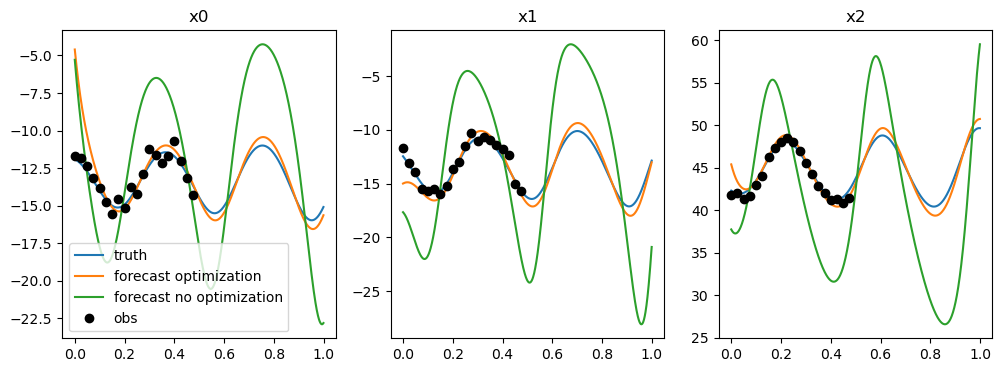

In [7]:
Tfor=1
t=np.arange(0,Tfor,dt)
xf=simulateX(xopt,Tfor,dt=dt)
xf3=simulateX(x0,Tfor,dt=dt)

plt.figure(0,figsize=(12,4))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.plot(t,Xtrue[2000:2000+len(t),i],label='truth')
    plt.plot(t,xf[:,i],label='forecast optimization')
    plt.plot(t,xf3[:,i],label='forecast no optimization')
    plt.title('x'+str(i))
    if Ndim==1 and i==0:
        plt.plot(t[:zobs.shape[1]*Nobs:Nobs],zobs[i,:],'ko',label='obs')
    elif Ndim==3:
        plt.plot(t[:zobs.shape[1]*Nobs:Nobs],zobs[i,:],'ko',label='obs')
    if i==0:
        plt.legend()
